In [ ]:
from qmt.physics_constants import parse_unit,to_float
from qmt.geometry import part_3d, build_3d_geometry
from qmt.materials import Materials, build_materials, make_materials_library
import pickle, logging
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

Load some 2D shapes from simple_wire.FCStd, and then build some a 3D structure out of them

In [ ]:
back_gate = part_3d.ExtrudePart("back_gate", "Sketch", z0=-0.2, thickness=0.1)
vacuum = part_3d.ExtrudePart("vacuum", "Sketch003", z0=-0.5, thickness=1.0)
wire = part_3d.ExtrudePart("wire", "Sketch002", z0=0.0, thickness=0.1)
shell = part_3d.ExtrudePart("shell", "Sketch002", z0=0.1, thickness=0.05)
build_order = [wire, shell, back_gate, vacuum]
file_path = './simple_wire.FCStd'
geo_data = build_3d_geometry(input_parts=build_order, input_file=file_path,
                             xsec_dict={'central':{'axis':(1.,0.,0.),'distance':0.}})
geo_data.write_fcstd('built_geo.fcstd')

At this point you can try opening built_geo.fcstd with FreeCAD and taking a look at the built shape. Feel free to skip this step if you're unfamiliar with the FreeCAD GUI.
We can check that our cross sections and parts are as expected:

In [3]:
geo_data.xsecs

{'central': {'axis': (1.0, 0.0, 0.0),
  'distance': 0.0,
  'polygons': {'wire_0': [[0.0, 0.05, 0.1],
    [0.0, 0.05, 0.0],
    [0.0, -0.05, 0.0],
    [0.0, -0.05, 0.1]],
   'shell_0': [[0.0, 0.05, 0.15000000000000002],
    [0.0, 0.05, 0.1],
    [0.0, -0.05, 0.1],
    [0.0, -0.05, 0.15000000000000002]],
   'back_gate_0': [[0.0, 0.25, -0.1],
    [0.0, 0.25, -0.2],
    [0.0, -0.25, -0.2],
    [0.0, -0.25, -0.1]],
   'vacuum_0': [[0.0, -0.5, 0.5],
    [0.0, 0.5, 0.5],
    [0.0, 0.5, -0.5],
    [0.0, -0.5, -0.5]],
   'vacuum_1': [[0.0, -0.25, -0.1],
    [0.0, 0.25, -0.1],
    [0.0, 0.25, -0.2],
    [0.0, -0.25, -0.2]],
   'vacuum_2': [[0.0, -0.05, 0.0],
    [0.0, 0.05, 0.0],
    [0.0, 0.05, 0.15000000000000002],
    [0.0, -0.05, 0.15000000000000002]]}}}

In [4]:
geo_data.parts

{'wire': <qmt.geometry.part_3d.ExtrudePart at 0x7f1fadf0f240>,
 'shell': <qmt.geometry.part_3d.ExtrudePart at 0x7f1fa7cba2e8>,
 'back_gate': <qmt.geometry.part_3d.ExtrudePart at 0x7f1fa7cba278>,
 'vacuum': <qmt.geometry.part_3d.ExtrudePart at 0x7f1fa7cba3c8>}

QMT can't do meshing, so we load a mesh from an example file

In [5]:
with open('mesh_data.pkl','rb') as file:
    mesh_data = pickle.load(file)

Determine the reference level and Al work function to get a 0.1 meV band offset between InSb and Al:

In [6]:
mat_lib = Materials()
Al_WF = mat_lib['Al']['workFunction']
InSb_EA = mat_lib['InSb']['electronAffinity']
InSb_BG = mat_lib['InSb']['directBandGap']
InSb_VBO = mat_lib['InSb']['valenceBandOffset']
Al_WF_level = 0.0-(Al_WF)
InSb_CB_level = 0.0-InSb_EA+InSb_VBO
WF_shift = 200.*parse_unit('meV')-(Al_WF_level-InSb_CB_level)
new_Al_WF = (Al_WF-WF_shift)
ref_level = -new_Al_WF/parse_unit('meV')

mat_lib = make_materials_library({"Al":{"workFunction": new_Al_WF}})
mat_data = build_materials(geo_data, 
                           {"back_gate": "Al", "vacuum": "air", "wire": "InSb", "shell": "Al"},
                           mat_lib)

You won't be able to run the simulation with QMT alone. Here we just load the file with simulation results

In [7]:
with open('tf_data.pkl','rb') as file:
    tf_data = pickle.load(file)

First, let's check that all of the boundary conditions are respected:

In [8]:
mesh_data.mesh_id_dict

{'wire': 3, 'shell': 4, 'back_gate': 2, 'vacuum': 1}

Great! Let's take a look at the potential profile to make sure it looks reasonable:

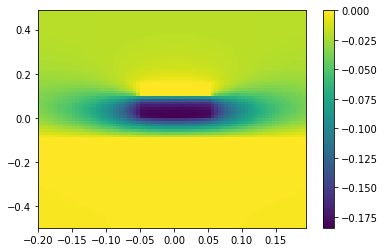

In [12]:
femcoords = tf_data.coordinates
femdata = tf_data.potential
xgrid, ygrid, zgrid = np.mgrid[0:1, -0.2:0.2:0.005, -0.5:0.5:0.0125]
plot_potential = griddata(femcoords, femdata, (xgrid, ygrid, zgrid), method='linear')
plt.pcolor(ygrid[0],zgrid[0],plot_potential[0])
plt.colorbar()
plt.show()

This looks fine. Let's now look at a line cut:

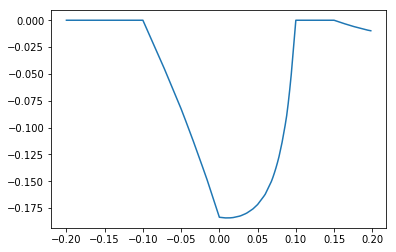

In [13]:
xgrid, ygrid, zgrid = np.mgrid[0:1, 0:1, -0.2:0.2:0.002]
potential_cut = griddata(femcoords, femdata, (xgrid, ygrid, zgrid), method='linear')
plt.plot(zgrid[0,0],potential_cut[0,0])
plt.show()

This all looks fine. In the region between 0.0 and 0.1, we have accumulation. Let's make sure this holds up when taking into account the conduction band offset:

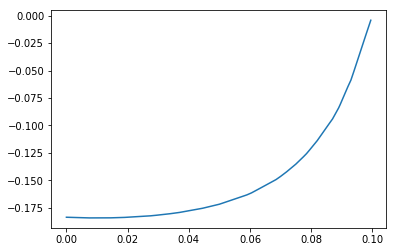

In [14]:
xgrid, ygrid, zgrid = np.mgrid[0:1, 0:1, 0:0.1:0.0005]
potential_cut = griddata(femcoords, femdata, (xgrid, ygrid, zgrid), method='linear')
plt.plot(zgrid[0,0],potential_cut[0,0])
plt.show()

Putting in the proper band offsets, we get:

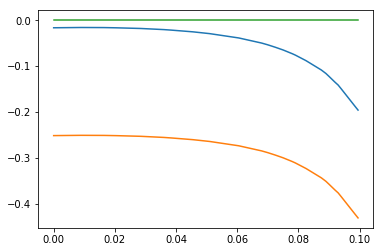

In [15]:
zvec = zgrid[0,0]
potential_cut = potential_cut[0,0]
offset_CB = (InSb_CB_level/parse_unit('meV')-ref_level)/1e3
offset_VB = offset_CB-InSb_BG/parse_unit('meV')/1e3
plt.plot(zvec,offset_CB-potential_cut)
plt.plot(zvec,offset_VB-potential_cut)
plt.plot(zvec,np.zeros(zvec.shape))
plt.show()